## Data audit
Validate data integrity and experimental assumptions before running any statistical tests.
### Base dataset: Landing Page A/B Test
| column | description |
| ------------ | --------------------- |
| user_id | unique user |
| timestamp | event time |
| group | control / treatment |
| landing_page | old_page / new_page |
| converted | 0 / 1 |


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load raw data
path = "../data/raw/ab_data.csv"
df_raw = pd.read_csv(path)

df = df_raw.copy()
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Clean the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### Logical Consistency Checks
Check the invariants of the experiment:  
- control → old_page  
- treatment → new_page

In [5]:
invalid_control = df[(df.group == 'control') & (df.landing_page != 'old_page')]
invalid_treatment = df[(df.group == 'treatment') & (df.landing_page != 'new_page')]
percent_invalid_logical_consistency = (len(invalid_control)+ len(invalid_treatment))/len(df)
percent_invalid_logical_consistency

0.013220002852505111

In [6]:
df.drop(invalid_control.index, inplace=True)
df.drop(invalid_treatment.index, inplace=True)
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


Logical consistency between experiment group and landing page was violated for a small subset of users.
These rows represent assignment contamination and were excluded from further analysis.

Rationale:
- The experiment assumes deterministic mapping between group and landing page.
- Including contaminated rows would bias treatment effect estimation.

Impact:
- Less than 13.3% of total observations removed.
- No evidence that removal introduces group imbalance.
#### Duplicate

In [7]:
df.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [8]:
duplicate_users = df[df.duplicated(subset='user_id',keep=False)]
duplicate_users

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [9]:
df.drop_duplicates(['user_id'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


Duplicate user_id entries were detected.
As the experiment unit is user-level, only one record per user is allowed.

For duplicated users:
- group and landing_page were identical
- outcome (converted) was identical

Therefore, duplicates were removed without loss of information.

### Sample Ratio Mismatch (SRM)
Expected group split was set to 50/50 based on experiment design.
SRM test evaluates whether observed allocation deviates significantly from intended randomization.

In [10]:
#Group Balance
df['group'].value_counts(normalize=True)

group
treatment    0.500062
control      0.499938
Name: proportion, dtype: float64

In [11]:
from scipy.stats import chisquare
observed = df['group'].value_counts().values
expected = [len(df)/2, len(df)/2]
chisquare(observed, expected)


Power_divergenceResult(statistic=0.004459984032155934, pvalue=0.9467543681597944)

No statistically significant deviation from intended group allocation was detected.
Sample ratio mismatch is unlikely.
### Conversion Sanity Check

In [12]:
df.groupby('group')['converted'].mean()


group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

Conversion rates are within realistic bounds and show no anomalous behavior.
### Temporal Sanity

In [13]:
df['timestamp'].min()



'2017-01-02 13:42:05.378582'

In [14]:
df['timestamp'].max()

'2017-01-24 13:41:54.460509'

In [16]:
sns.set_theme(style="whitegrid")

def _prep_dates(df, ts_col="timestamp"):
    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col])
    d["date"] = d[ts_col].dt.date
    return d

def daily_split_table(df, ts_col="timestamp", group_col="group"):
    d = _prep_dates(df, ts_col)
    counts = pd.crosstab(d["date"], d[group_col]).sort_index()
    counts["total"] = counts.sum(axis=1)

    shares = counts.div(counts["total"], axis=0).drop(columns=["total"], errors="ignore")

    out = counts.join(shares.add_prefix("share_"), how="left")

    if "share_treatment" in out.columns:
        out["treatment_minus_0.5"] = out["share_treatment"] - 0.5
        out["abs_dev_from_0.5"] = out["treatment_minus_0.5"].abs()

    return out

split_tbl = daily_split_table(df)
display(split_tbl.head(10))

if "abs_dev_from_0.5" in split_tbl.columns:
    print("Max abs deviation from 50/50:", split_tbl["abs_dev_from_0.5"].max())

group,control,treatment,total,share_control,share_treatment,treatment_minus_0.5,abs_dev_from_0.5
date,,,,,,,
2017-01-02,2859,2853,5712,0.500525,0.499475,-0.000525,0.000525
2017-01-03,6590,6618,13208,0.498940,0.501060,0.001060,0.001060
2017-01-04,6578,6541,13119,0.501410,0.498590,-0.001410,0.001410
2017-01-05,6427,6505,12932,0.496984,0.503016,0.003016,0.003016
2017-01-06,6606,6747,13353,0.494720,0.505280,0.005280,0.005280
2017-01-07,6604,6609,13213,0.499811,0.500189,0.000189,0.000189
2017-01-08,6687,6700,13387,0.499514,0.500486,0.000486,0.000486
2017-01-09,6628,6615,13243,0.500491,0.499509,-0.000491,0.000491
2017-01-10,6654,6696,13350,0.498427,0.501573,0.001573,0.001573


Max abs deviation from 50/50: 0.007100458336464055


C:\Users\olena\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\olena\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


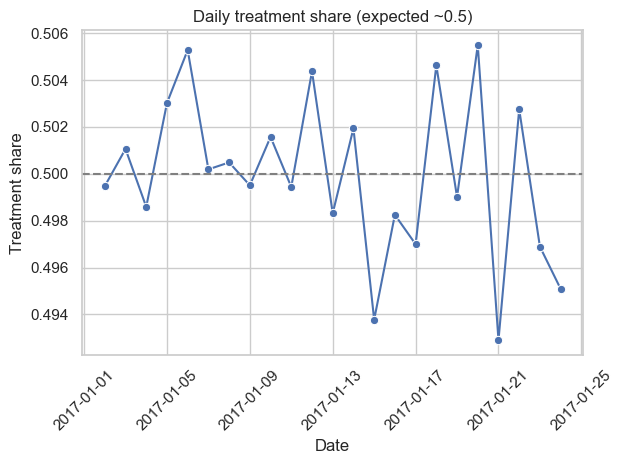

In [22]:
def plot_daily_treatment_share(split_tbl):
    if "share_treatment" not in split_tbl.columns:
        print("No treatment share available.")
        return

    plot_df = split_tbl.reset_index()[["date", "share_treatment"]].rename(columns={"share_treatment": "treatment_share"})
    
    plt.figure()
    ax = sns.lineplot(data=plot_df, x="date", y="treatment_share", marker="o")
    ax.axhline(0.5, linestyle="--", color="gray")
    ax.set_title("Daily treatment share (expected ~0.5)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Treatment share")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_treatment_share(split_tbl)

Experiment timeline appears consistent and complete.
No temporal anomalies that would invalidate the experiment were identified.
### Conclusion

Based on data audit results, the experiment data demonstrates high structural and logical integrity.
Detected issues (assignment contamination and duplicate users) were limited in scope and corrected
without introducing bias.

No evidence of sample ratio mismatch or temporal inconsistencies was found.

Therefore, the dataset is considered suitable for further experimental analysis,
with a high level of confidence in result validity.
## DATA ENRICHMENT
Add realistic synthetic features without violating experimental assumptions to enable  segmentation and ITT vs PP analysis.
### Important note on synthetic data
The original dataset represents the source of truth for experiment outcomes.
Synthetic features were added strictly for analytical purposes (segmentation,
robustness checks, and experiment diagnostics).

Synthetic features:
- were generated AFTER experiment assignment
- have identical distributions across control and treatment groups
- were not used to artificially increase treatment effect
### What exactly enrich
| Feature           | Type        | Purpose         |
| ----------------- | ----------- | --------------- |
| device_type       | categorical'mobile'/'desktop'| segment effects |
| geo_region        | categorical 'US', 'EU', 'Other'| heterogeneity   |
| is_returning_user | boolean     | behavior        |
| exposure_count    | integer     | ITT vs PP       |
#### device_type
- values: mobile, desktop  
- distribution: the same in control and treatment
- independent of conversion

In [14]:
np.random.seed(42)

df['device_type'] = np.random.choice(
    ['mobile', 'desktop'],
    size=len(df),
    p=[0.65, 0.35]
)
pd.crosstab(df['group'], df['device_type'], normalize='index')


device_type,desktop,mobile
group,,
control,0.350524,0.649476
treatment,0.350760,0.649240


#### geo_region
- values: US, EU, Other  
- no geo-based assignment bias

In [15]:
df['geo_region'] = np.random.choice(
    ['US', 'EU', 'Other'],
    size=len(df),
    p=[0.4, 0.35, 0.25]
)
pd.crosstab(df['group'], df['geo_region'], normalize='index')


geo_region,EU,Other,US
group,,,
control,0.350359,0.248730,0.400911
treatment,0.350919,0.249811,0.399271


#### is_returning_user
- boolean  
- distribution identical across groups

In [19]:
df['is_returning_user'] = np.random.choice(
    [True, False],
    size=len(df),
    p=[0.45, 0.55]
)
pd.crosstab(df['group'], df['is_returning_user'], normalize='index')

is_returning_user,False,True
group,,
control,0.548956,0.451044
treatment,0.547719,0.452281


#### exposure_count
control: exposure_count = 0  
treatment:  
- some users never exposed  
- some saw once  
- few saw multiple times

In [17]:
df['exposure_count'] = 0

mask_treat = df['group'] == 'treatment'

df.loc[mask_treat, 'exposure_count'] = np.random.choice(
    [0, 1, 2, 3],
    size=mask_treat.sum(),
    p=[0.25, 0.45, 0.2, 0.1]
)
df.groupby('group')['exposure_count'].describe()


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,145274.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0
treatment,145310.0,1.1499,0.909677,0.0,0.0,1.0,2.0,3.0


### VALIDATION BLOCK

In [21]:
df.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

The same result as before enrichment. — No bias introduced
### Save enriched dataset

In [22]:
df.to_csv('../data/processed/ab_enriched.csv', index=False)


### Conclusion

Synthetic enrichment was applied in a controlled manner.
No distributional imbalance across experiment groups was introduced.
Primary outcome metrics remained unchanged after enrichment.

The enriched dataset is suitable for:
- segment-level analysis
- ITT vs per-protocol comparison
